In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
import xgboost as xgb
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
import time
import os
from typing import Dict, List, Tuple
from tensorflow.keras import layers, models
from typing import List, Dict, Tuple, Optional
from pathlib import Path



In [2]:
df = pd.read_csv("/Users/sohinikar/M.Tech_Dissertation/Obfuscated-MalMem2022.csv")
df.head()

,Category,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,...,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric,Class
0,Benign,45,17,10.555556,0,202.844444,1694,38.500000,9129,212.302326,...,221,26,24,116,0,121,87,0,8,Benign
1,Benign,47,19,11.531915,0,242.234043,2074,44.127660,11385,242.234043,...,222,26,24,118,0,122,87,0,8,Benign
2,Benign,40,14,14.725000,0,288.225000,1932,48.300000,11529,288.225000,...,222,26,27,118,0,120,88,0,8,Benign
3,Benign,32,13,13.500000,0,264.281250,1445,45.156250,8457,264.281250,...,222,26,27,118,0,120,88,0,8,Benign
4,Benign,42,16,11.452381,0,281.333333,2067,49.214286,11816,281.333333,...,222,26,24,118,0,124,87,0,8,Benign


In [3]:
df.describe()

,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,handles.nport,...,svcscan.nservices,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric
count,58596.000000,58596.000000,58596.000000,58596.0,58596.000000,58596.000000,58596.000000,5.859600e+04,58596.000000,58596.0,...,58596.000000,58596.000000,58596.000000,58596.000000,58596.000000,58596.0,58596.000000,58596.000000,58596.000000,58596.000000
mean,41.394771,14.713837,11.341655,0.0,247.509819,1810.805447,43.707806,1.025858e+04,249.560958,0.0,...,391.347549,221.406581,25.996245,25.063417,116.879514,0.0,121.995546,86.905659,0.000853,7.999881
std,5.777249,2.656748,1.588231,0.0,111.857790,329.782639,5.742023,4.866864e+03,145.999866,0.0,...,4.529704,1.991087,0.170790,1.529628,1.550401,0.0,2.822858,3.134117,0.029199,0.010929
min,21.000000,8.000000,1.650000,0.0,34.962500,670.000000,7.333333,3.514000e+03,71.139241,0.0,...,94.000000,55.000000,6.000000,7.000000,26.000000,0.0,30.000000,50.000000,0.000000,7.000000
25%,40.000000,12.000000,9.972973,0.0,208.725000,1556.000000,38.833333,8.393000e+03,209.648228,0.0,...,389.000000,221.000000,26.000000,24.000000,116.000000,0.0,121.000000,87.000000,0.000000,8.000000
50%,41.000000,15.000000,11.000000,0.0,243.963710,1735.000000,42.781524,9.287500e+03,247.208951,0.0,...,389.000000,221.000000,26.000000,24.000000,116.000000,0.0,122.000000,87.000000,0.000000,8.000000
75%,43.000000,16.000000,12.861955,0.0,289.974322,2087.000000,49.605280,1.219300e+04,291.355050,0.0,...,395.000000,222.000000,26.000000,27.000000,118.000000,0.0,123.000000,88.000000,0.000000,8.000000
max,240.000000,72.000000,16.818182,0.0,24845.951220,3443.000000,53.170732,1.047310e+06,33784.193550,0.0,...,395.000000,222.000000,26.000000,27.000000,118.000000,0.0,129.000000,89.000000,1.000000,8.000000


In [4]:
df.shape

(58596, 57)

# Data Cleaning

In [5]:
# checking all the values in the columns are indetical
for column in df.columns:
    if df[column].nunique() == 1:
        print(f"All values in {column} are identical.")

All values in pslist.nprocs64bit are identical.
All values in handles.nport are identical.
All values in svcscan.interactive_process_services are identical.


In [6]:
columns_to_drop = ['pslist.nprocs64bit', 'handles.nport', 'svcscan.interactive_process_services']

# Drop the specified columns
df.drop(columns=columns_to_drop, inplace=True)

In [7]:
#checking for columns with null values

null_columns = df.columns[df.isnull().any()]
print("Columns with nulls:", list(null_columns))

Columns with nulls: []


# Encoding

In [8]:
df['Class'] = df['Class'].map({'Benign': 0, 'Malware': 1}) if df['Class'].dtype == 'object' else df['Class']

# sanity check of data before splitting

In [9]:
print("\nData Info:")
print(df.info())
print("\nFirst Few Rows:")
print(df.head())


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58596 entries, 0 to 58595
Data columns (total 54 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Category                                58596 non-null  object 
 1   pslist.nproc                            58596 non-null  int64  
 2   pslist.nppid                            58596 non-null  int64  
 3   pslist.avg_threads                      58596 non-null  float64
 4   pslist.avg_handlers                     58596 non-null  float64
 5   dlllist.ndlls                           58596 non-null  int64  
 6   dlllist.avg_dlls_per_proc               58596 non-null  float64
 7   handles.nhandles                        58596 non-null  int64  
 8   handles.avg_handles_per_proc            58596 non-null  float64
 9   handles.nfile                           58596 non-null  int64  
 10  handles.nevent                          58596 

In [10]:
print("DataFrame Shape:", df.shape)
print("Class Distribution:", df["Class"].value_counts())

DataFrame Shape: (58596, 54)
Class Distribution: Class
0    29298
1    29298
Name: count, dtype: int64


In [11]:
X = df.drop(columns=['Class','Category'])
y = df["Class"]

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Steep rise initially:
The first ~10 components capture a large portion of the total variance — roughly 90–95%.
This means most of the useful information is concentrated in those first few components.

Elbow point (approx at component 10–15):
After ~15 components, the curve flattens — additional components add very little new information (variance).

Plateau near 1.0:
Around 20–25 components, you reach nearly 100% variance retained, so including more components beyond that is redundant.

# Splitting the data

In [36]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=7)

In [37]:
X_test.shape

(17579, 52)

In [38]:
# Ensure numpy arrays
X_test = np.asarray(X_test)
y_test = np.asarray(y_test).reshape(-1)

# Randomly pick 5888 indices
rng = np.random.default_rng(42)  # seed for reproducibility
sample_idx = rng.choice(len(X_test), size=5888, replace=False)

# Extract sampled sets
X_sampled = X_test[sample_idx]
y_sampled = y_test[sample_idx]

# Remove those rows to form reduced test set
mask = np.ones(len(X_test), dtype=bool)
mask[sample_idx] = False

X_test = X_test[mask]
y_test = y_test[mask]

print("X_sampled:", X_sampled.shape)   # (5888, 52)
print("y_sampled:", y_sampled.shape)   # (5888,)
print("Remaining X_test:", X_test.shape)  # (17579-5888, 52) = (11691, 52)
print("Remaining y_test:", y_test.shape)  # (11691,)

X_sampled: (5888, 52)
y_sampled: (5888,)
Remaining X_test: (11691, 52)
Remaining y_test: (11691,)


In [39]:
# ---- config ----
BASE_DIR_FNN  = Path("/Users/sohinikar/FL/M.Tech_Dissertation/data/FNN_BC_test_data")
BASE_DIR_LSTM = Path("/Users/sohinikar/FL/M.Tech_Dissertation/data/LSTM_BC_test_data")
USER_COUNT = 128
TOTAL_SAMPLES = len(X_sampled)   # should be 5888
SAMPLES_PER_USER = TOTAL_SAMPLES // USER_COUNT  # 46

# ---- ensure numpy arrays ----
X_sampled = np.asarray(X_sampled)
y_sampled = np.asarray(y_sampled).reshape(-1)

n, d = X_sampled.shape
assert n == len(y_sampled), "X_sampled and y_sampled must have the same number of rows"

# ---- prepare LSTM reshaped data ----
X_sampled_lstm = X_sampled.reshape((n, 1, d)).astype(np.float32)
y_sampled_lstm = y_sampled.astype(np.float32)

# ---- helper to save per-user ----
def save_user_data(base_dir, X, y, is_lstm=False):
    base_dir.mkdir(parents=True, exist_ok=True)
    cols = [f"f{i:02d}" for i in range(X.shape[-1])] if not is_lstm else [f"t0_f{i:02d}" for i in range(X.shape[-1])]

    for user_id in range(1, USER_COUNT + 1):
        start = (user_id - 1) * SAMPLES_PER_USER
        end = start + SAMPLES_PER_USER

        user_dir = base_dir / f"user_{user_id:03d}"
        user_dir.mkdir(parents=True, exist_ok=True)

        if is_lstm:
            # flatten (samples, 1, features) -> (samples, features)
            X_chunk = X[start:end, 0, :]
        else:
            X_chunk = X[start:end]

        y_chunk = y[start:end]

        # Save features
        pd.DataFrame(X_chunk, columns=cols).to_csv(user_dir / "X.csv", index=False)
        # Save labels
        pd.DataFrame({"label": y_chunk}).to_csv(user_dir / "y.csv", index=False)

# ---- save both FNN + LSTM sets ----
save_user_data(BASE_DIR_FNN,  X_sampled,      y_sampled,      is_lstm=False)
save_user_data(BASE_DIR_LSTM, X_sampled_lstm, y_sampled_lstm, is_lstm=True)

print(f"✅ Done. Created {USER_COUNT} folders each under:")
print(f"   {BASE_DIR_FNN}")
print(f"   {BASE_DIR_LSTM}")


✅ Done. Created 128 folders each under:
   /Users/sohinikar/FL/M.Tech_Dissertation/data/FNN_BC_test_data
   /Users/sohinikar/FL/M.Tech_Dissertation/data/LSTM_BC_test_data


In [34]:
X_test.shape

(11691, 52)

In [35]:
y_test.shape

(11691,)

# Feedforward Neural Network for Binary Classification (FNN-BC)

In [14]:
early_stop = EarlyStopping(
    monitor="accuracy",      # or "val_accuracy"
    mode="max",
    patience=0,              # stop as soon as it stops improving
    min_delta=0.0,           # minimum change
    verbose=1
)

In [15]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(52,)),  # 52 input features
    tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal'),  # hidden layer 1
    tf.keras.layers.Dropout(0.5),  # dropout to avoid overfitting
    tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal'),  # hidden layer 2
    tf.keras.layers.Dropout(0.5),  # dropout to avoid overfitting
    tf.keras.layers.Dense(1, activation='sigmoid')  # output layer for binary classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0005),  # optimizer
    loss='binary_crossentropy',            # binary classification loss
    metrics=['accuracy', tf.keras.metrics.Recall()]  # metrics
)

# Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 651 (2.54 KB)

 Trainable params: 651 (2.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
full_start = time.time()
model.fit(X_train, y_train,
          epochs=30,
          batch_size=64,
          callbacks=[early_stop]
)
full_end = time.time()
print(f"Training time = {full_end - full_start:.3f} seconds")

Epoch 1/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - accuracy: 0.9656 - loss: 0.0632 - recall: 0.9527
Epoch 2/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - accuracy: 0.9657 - loss: 0.0650 - recall: 0.9509
Epoch 3/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - accuracy: 0.9656 - loss: 0.0673 - recall: 0.9505
Epoch 4/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - accuracy: 0.9669 - loss: 0.0573 - recall: 0.9499
Epoch 5/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - accuracy: 0.9677 - loss: 0.0556 - recall: 0.9526
Epoch 6/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - accuracy: 0.9679 - loss: 0.0539 - recall: 0.9488
Epoch 7/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - accuracy: 0.9693 - loss: 0.0547 - recall: 0.9525
Epoch 8/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - accuracy: 0.9683 - loss: 0.0508 - recall: 0.9538
Epoch 9/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - accuracy: 0.9686 - loss: 0.0510 - recall: 0.9538
Epoch 10/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step 

## LSTM-BC: Long Short-Term Memory for Binary Classification

In [18]:
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1])).astype(np.float32)
X_test_lstm  = X_test.reshape((X_test.shape[0], 1, X_test.shape[1])).astype(np.float32)

In [19]:
y_train = np.asarray(y_train).astype(np.float32)
y_test  = np.asarray(y_test).astype(np.float32)

In [20]:
lstm_bc = tf.keras.Sequential([
    tf.keras.Input(shape=(1, 52)),                # (timesteps, 52 features)
    tf.keras.layers.LSTM(13, activation='relu'),     # outputs 13-d vector
    tf.keras.layers.Dense(1, activation='sigmoid')   # binary output
])

lstm_bc.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(name="recall")]
)

lstm_bc.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 13)             │         3,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,446 (13.46 KB)

 Trainable params: 3,446 (13.46 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
full_start = time.time()
lstm_bc.fit(X_train_lstm, y_train,
          epochs=30,
          batch_size=64,
          verbose=1,
          callbacks=[early_stop]
)
full_end = time.time()
print(f"Training time = {full_end - full_start:.3f} seconds")


Epoch 1/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 1s 445us/step - accuracy: 0.9030 - loss: 0.3179 - recall: 0.8512
Epoch 2/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.9971 - loss: 0.0160 - recall: 0.9981
Epoch 3/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.9980 - loss: 0.0089 - recall: 0.9980
Epoch 4/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - accuracy: 0.9989 - loss: 0.0066 - recall: 0.9989
Epoch 5/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.9990 - loss: 0.0052 - recall: 0.9991
Epoch 6/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.9991 - loss: 0.0040 - recall: 0.9991
Epoch 7/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.9991 - loss: 0.0041 - recall: 0.9991
Epoch 8/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.9993 - loss: 0.0039 - recall: 0.9995
Epoch 9/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.9994 - loss: 0.0034 - recall: 0.9997
Epoch 10/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step 

550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - accuracy: 0.9982 - loss: 0.0076 - recall: 0.9988 
Test Loss: 0.0070
Test Accuracy: 0.9981
Test precision: 0.9986
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8767
         1.0       1.00      1.00      1.00      8812

    accuracy                           1.00     17579
   macro avg       1.00      1.00      1.00     17579
weighted avg       1.00      1.00      1.00     17579



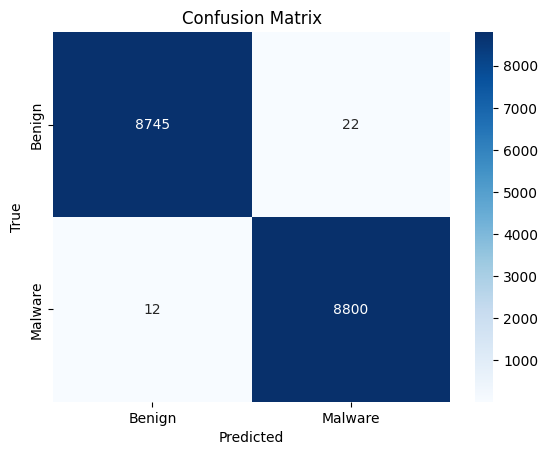

In [22]:
loss, acc , precision= model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")
print(f"Test precision: {precision:.4f}")

# Classification Report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malware"], yticklabels=["Benign", "Malware"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step - accuracy: 0.9992 - loss: 0.0014 - recall: 0.9999   
Test Loss: 0.0012
Test Accuracy: 0.9993
Test precision: 0.9999
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8767
         1.0       1.00      1.00      1.00      8812

    accuracy                           1.00     17579
   macro avg       1.00      1.00      1.00     17579
weighted avg       1.00      1.00      1.00     17579



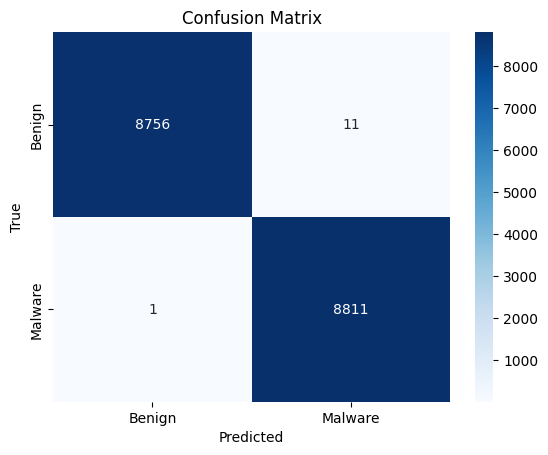

In [22]:
loss, acc , precision= lstm_bc.evaluate(X_test_lstm, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")
print(f"Test precision: {precision:.4f}")

# Classification Report
y_pred = (lstm_bc.predict(X_test_lstm) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malware"], yticklabels=["Benign", "Malware"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [24]:
# Save full model (preferred modern way)
model.save("global_FNN_model.keras")
lstm_bc.save("global_lstm_model.keras")